# Hyperparameter Tuning con Optuna

## Objetivos

- Comprender qué son los **hyperparámetros** y por qué necesitan optimización
- Aprender a usar **Optuna** para buscar automáticamente la mejor configuración
- Definir espacios de búsqueda con diferentes tipos de parámetros
- Comparar configuraciones de modelos
- Entrenar el modelo final con los mejores hyperparámetros

In [ ]:
import os
import shutil
import sys

if "google.colab" in sys.modules:
    # Move to top content folder
    while not os.getcwd().endswith("content"):
        os.chdir("..")
    # Check if repo has already been cloned
    if not os.path.exists("intro-ML"): # if not, clone it
      print("Cloning repo...")
      !git clone https://github.com/isfons/intro-ML.git
    # Set the correct working directory
    %cd intro-ML
    # Update repo
    !git pull

if not shutil.which("optuna"):
    !pip install -q optuna
assert(shutil.which("optuna"))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import ipywidgets as widgets

from utils import plot_learning_curve, plot_pred_vs_obs

print(f"PyTorch version: {torch.__version__}")
print(f"Optuna version: {optuna.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Fijar seeds para reproducibilidad
np.random.seed(42)
torch.manual_seed(42)

PyTorch version: 2.10.0+cpu
Optuna version: 4.7.0
CUDA available: False


# **Cargar datos**

En esta demostración se va a utilizar la base de datos de la central de ciclo combinado, disponible en [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant).

In [2]:
def load_data():
    """Cargar datos de la central eléctrica ciclo combinado desde un archivo .csv"""
    if 'google.colab' in str(get_ipython()):
      dataset_path = 'https://raw.githubusercontent.com/cursos-COnCEPT/curso-tensorflow/refs/heads/main/CCP.csv'
    else:
      dataset_path = os.getcwd() + '\\CCP.csv'

    dataset = pd.read_csv(dataset_path)
    return dataset

def split_data(dataset):
    """Separar datos en train/validation/test."""
    train_ratio = 0.70
    val_ratio = 0.15

    X = dataset.sample(frac=train_ratio+val_ratio, random_state=42)
    X_test = dataset.drop(X.index)
    X_train = X.sample(frac=train_ratio/(val_ratio+train_ratio), random_state=42)
    X_val = X.drop(X_train.index)

    y_train = X_train.pop('PE')
    y_test = X_test.pop('PE')
    y_val = X_val.pop('PE')

    return X_train, y_train, X_val, y_val, X_test, y_test

def scale_inputs(X_train, X_val, X_test):
    """Aplicar normalización Z-scores a los datos de entrada."""
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_norm = scaler.transform(X_train)
    X_test_norm  = scaler.transform(X_test)
    X_val_norm   = scaler.transform(X_val)

    return X_train_norm, X_val_norm, X_test_norm

def create_datasets(X_train, y_train, X_val, y_val, X_test, y_test, device):
    """Transformar NumPy arrays a TensorDataset."""
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values.copy()).reshape(-1, 1).to(device)

    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val.values.copy()).reshape(-1, 1).to(device)

    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.FloatTensor(y_test.values.copy()).reshape(-1, 1).to(device)

    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    val_ds = TensorDataset(X_val_tensor, y_val_tensor)
    test_ds = TensorDataset(X_test_tensor, y_test_tensor)

    return train_ds, val_ds, test_ds

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ds = load_data()
X_train, y_train, X_val, y_val, X_test, y_test = split_data(ds)
X_train_norm, X_val_norm, X_test_norm = scale_inputs(X_train, X_val, X_test)
train_ds, val_ds, test_ds = create_datasets(X_train_norm, y_train, X_val_norm, y_val, X_test_norm, y_test, device)
input_size = X_train.shape[-1]

print(f"El entrenamiento se va a ejecutar en {device}.\nNúmero de variables de entrada a la red neuronal: {input_size}")


El entrenamiento se va a ejecutar en cpu.
Número de variables de entrada a la red neuronal: 4


# **Resumen:** pasos básicos para el entrenamiento de una red neuronal
**Paso 1:** Definir el modelo

In [4]:
class FlexibleModel(nn.Module):
    """
    Modelo de red neuronal con número configurable de capas ocultas y neuronas.
    
    Args:
        input_dim: Dimensión de entrada
        device: Dispositivo (CPU o CUDA)
        hidden_units: Número de neuronas en cada capa oculta
        hidden_layers: Número de capas ocultas
    """
    def __init__(self, input_size, device, hidden_units = 10, hidden_layers = 1, dropout_rate=0.0):
        super().__init__()
        layers = []
        in_features = input_size
        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_features = hidden_units
        layers.append(nn.Linear(in_features, 1))
        self.net = nn.Sequential(*layers)
        self.device = device

    def forward(self, x):
        return self.net(x)

**Paso 2:** Configurar el método de entrenamiento

In [ ]:
def train_model(model, train_loader, val_loader, epochs = 200, lr = 0.001, show_progress_bar = True):
    """Entrena una red neuronal y devuelve la evolución de la función de pérdidas."""
    loss_fcn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    device = train_loader.dataset.tensors[0].device

    history = {
        'train_loss': [],
        'val_loss': [],
    }

    for epoch in tqdm(range(epochs), disable = show_progress_bar):

        model.train()  
        train_loss = 0.0      
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch)
            loss = loss_fcn(predictions, y_batch)
            
            optimizer.zero_grad()
            loss.backward()    
            optimizer.step()       
            
            train_loss += loss.item() 
        
        train_loss /= len(train_loader.dataset)

        model.eval()  
        val_loss = 0.0        
        with torch.no_grad():  
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                predictions = model(X_batch)
                loss = loss_fcn(predictions, y_batch)
                
                val_loss += loss.item() 
        
        val_loss /= len(val_loader.dataset)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
    
    return history

**Paso 3:** Entrenar el modelo para una combinación fija de hiperparámetros

In [ ]:
def run_experiment(hidden_units, hidden_layers, lr, batch_size, dropout_rate, epochs):
    """Ejecuta un experimento de entrenamiento con los hiperparámetros especificados."""   
    train_loader = DataLoader(train_ds, batch_size=batch_size)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    
    model = FlexibleModel(input_size = X_train.shape[-1],
                          device = device,
                          hidden_layers=hidden_layers,
                          hidden_units=hidden_units,
                          dropout_rate=dropout_rate).to(device)
    
    history = train_model(model, train_loader, val_loader, epochs=epochs, lr=lr, show_progress_bar = False)
    
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    plot_learning_curve(history,axes[0])
    plot_pred_vs_obs(model, X_test_norm, y_test, axes[1], label = "Test set")

# **Introducción a los hiperparámetros**

### ¿Parámetros vs Hyperparámetros?

**Parámetros:**
- Los **pesos** (weights) y **sesgos** (biases) de la red neuronal
- Se aprenden automáticamente durante el entrenamiento
- NO se establecen manualmente

**Hyperparámetros:**
- Configuraciones que deben fijarse **antes** de entrenar
- NO se aprenden automáticamente

**Ejemplos de hyperparámetros:**
- Número de capas 
- Número de neuronas por capa 
- Learning rate
- Batch size
- Tasa de Dropout
- Coeficiente de regularización L2
- Epochs, patience para early stopping

### ¿Por qué optimizar hyperparámetros?

La elección de hyperparámetros tiene un **GRAN IMPACTO** en el rendimiento final:
- Learning rate muy alto → Entrenamiento inestable
- Learning rate muy bajo → Convergencia lenta
- Modelo muy pequeño → Underfitting
- Modelo muy grande → Overfitting
- Batch size afecta estabilidad y velocidad

In [7]:
widgets.interact(run_experiment,
                 hidden_units = widgets.IntSlider(min=10, max=250, step=10, value=10, description="Hidden units", continuous_update = False),
                 hidden_layers = widgets.IntSlider(min=1, max=4, value=1, step=1, description="Hidden layers", continuous_update = False),
                 dropout_rate = widgets.FloatSlider(min=0.0, max=0.5, step=0.1, value=0.0, description="Dropout rate", continuous_update=False),
                 lr = widgets.FloatLogSlider(min=-5, max=-1, step = 1, value = -3, base=10, description="Learning rate", continuous_update = False),
                 batch_size = widgets.IntSlider(min=50, max=500, step=50, value=150, description="Batch size", continuous_update = False),
                 epochs = widgets.IntSlider(min=50, max=500, step = 25, value = 50, description = "Epochs", continuous_update = False)
                 )

interactive(children=(IntSlider(value=10, continuous_update=False, description='Hidden units', max=250, min=10…

<function __main__.run_experiment(hidden_units, hidden_layers, lr, batch_size, dropout_rate, epochs)>

# **Optuna**

**Optuna** es una librería de Python para el ajuste de hiperparámetros utilizando principios de optimización bayesiana.

**Conceptos clave:**

- **Trial:** Una prueba con una combinación de hyperparámetros
- **Study:** El proceso completo de optimización
- **Objective:** La función que Optuna minimiza/maximiza
- **Bayesian Optimization:** Algoritmo que aprende qué parámetros funcionan mejor
- **Pruning:** Detener trials que van mal temprano


**Instalación:**
```bash
pip install optuna
```

**Documentación:** [Optuna oficial](https://optuna.readthedocs.io/)

## Paso 1: Definir el espacio de búsqueda

### ¿Qué parámetros vamos a optimizar?

Optaremos por optimizar los siguientes hyperparámetros:

1. **`hidden_size1`:** Número de neuronas en la 1ª capa (16-256)
2. **`hidden_size2`:** Número de neuronas en la 2ª capa (8-128)
3. **`learning_rate`:** Opciones discretas [0.001, 0.005, 0.01]
4. **`dropout_rate`:** Tasa de dropout (0.0-0.5)
5. **`batch_size`:** Tamaño de batch [32, 64, 128, 256]

### Tipos de parámetros en Optuna

- **`trial.suggest_int()`:** Parámetros enteros (ej: número de neuronas)
- **`trial.suggest_float()`:** Parámetros continuos (ej: learning rate)
- **`trial.suggest_categorical()`:** Opciones discretas (ej: batch size)

**Referencia:** [`Optuna API - Trial object`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html)

In [8]:
def objective(trial):
    """
    Función objetivo para Optuna.
    Optuna intentará MINIMIZAR el valor retornado (validation loss).
    """
    EPOCHS = 10

    # Definir el espacio de búsqueda
    hidden_layers = trial.suggest_int('hidden_layers', 1, 3, step=1)
    hidden_units = trial.suggest_int('hidden_units', 8, 128, step=8)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 5e-3, 1e-2])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    
    # Crear DataLoader con el batch size correspondiente
    train_loader = DataLoader(train_ds, batch_size=batch_size)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    # Definir modelo
    model = FlexibleModel(input_size=input_size, 
                          device=device,
                          hidden_units=hidden_units, 
                          hidden_layers=hidden_layers,
                          dropout_rate=dropout_rate)
    
    # Entrenar modelo
    history = train_model(model, train_loader, val_loader, EPOCHS, learning_rate)
    
    return history["val_loss"][-1] # Devolver el MSE en validación al final del entrenamiento

## Paso 2: Crear y ejecutar el *Study* de Optuna

El objetivo de un *study* es encontrar los mejores hiperparámetros a partir de múltiples pruebas o *trials*.

**Opciones principales:**
- `direction='minimize'` o `'maximize'` - ¿qué optimizamos?
- `sampler` - Algoritmo de búsqueda (TPE por defecto - muy bueno)
- `pruner` - Detiene trials malos temprano

**Referencia:** [`optuna.create_study()`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.create_study.html)

In [9]:
NUM_TRIALS = 10 # Número de configuraciones a probar

study = optuna.create_study(
    direction='minimize',  # Queremos minimizar validation loss
    pruner=optuna.pruners.MedianPruner(),  # Detiene trials que van mal
)

study.optimize(
    objective,
    n_trials=NUM_TRIALS,  
    show_progress_bar=True,
    gc_after_trial=True,  # Liberar memoria después de cada trial
)

[I 2026-02-05 13:03:17,041] A new study created in memory with name: no-name-ba57f261-a6dd-4143-8dc1-bd211b5f1c79


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


[I 2026-02-05 13:03:20,072] Trial 0 finished with value: 816.9930204703833 and parameters: {'hidden_layers': 1, 'hidden_units': 48, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 256}. Best is trial 0 with value: 816.9930204703833.


100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


[I 2026-02-05 13:03:22,577] Trial 1 finished with value: 6.374991876156903 and parameters: {'hidden_layers': 1, 'hidden_units': 48, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 128}. Best is trial 1 with value: 6.374991876156903.


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


[I 2026-02-05 13:03:25,317] Trial 2 finished with value: 2.4925483517530487 and parameters: {'hidden_layers': 3, 'hidden_units': 72, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 256}. Best is trial 2 with value: 2.4925483517530487.


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


[I 2026-02-05 13:03:27,757] Trial 3 finished with value: 19.26148847520144 and parameters: {'hidden_layers': 1, 'hidden_units': 128, 'dropout_rate': 0.0, 'learning_rate': 0.005, 'batch_size': 128}. Best is trial 2 with value: 2.4925483517530487.


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


[I 2026-02-05 13:03:30,987] Trial 4 finished with value: 38.12742966708406 and parameters: {'hidden_layers': 2, 'hidden_units': 96, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 128}. Best is trial 2 with value: 2.4925483517530487.


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


[I 2026-02-05 13:03:34,067] Trial 5 finished with value: 693.5280378919861 and parameters: {'hidden_layers': 3, 'hidden_units': 8, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 256}. Best is trial 2 with value: 2.4925483517530487.


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


[I 2026-02-05 13:03:42,882] Trial 6 finished with value: 28.20766567535932 and parameters: {'hidden_layers': 3, 'hidden_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32}. Best is trial 2 with value: 2.4925483517530487.


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


[I 2026-02-05 13:03:49,456] Trial 7 finished with value: 33.17427948742378 and parameters: {'hidden_layers': 2, 'hidden_units': 112, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 128}. Best is trial 2 with value: 2.4925483517530487.


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


[I 2026-02-05 13:04:03,651] Trial 8 finished with value: 2.4683218819754464 and parameters: {'hidden_layers': 3, 'hidden_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}. Best is trial 8 with value: 2.4683218819754464.


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


[I 2026-02-05 13:04:13,947] Trial 9 finished with value: 56.32377325715919 and parameters: {'hidden_layers': 3, 'hidden_units': 48, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32}. Best is trial 8 with value: 2.4683218819754464.


## Paso 3: Analizar resultados de Optuna

In [10]:
best_trial = study.best_trial

print("\n MEJOR CONFIGURACIÓN ENCONTRADA\n")
print(f"Validation Loss: {best_trial.value:.6f}")
print(f"\nHyperparámetros:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")


 MEJOR CONFIGURACIÓN ENCONTRADA

Validation Loss: 2.468322

Hyperparámetros:
  hidden_layers: 3
  hidden_units: 128
  dropout_rate: 0.2
  learning_rate: 0.001
  batch_size: 32


In [11]:
# Resumen de trials
trials_df = study.trials_dataframe()
print(f"\nResumen de {len(trials_df)} trials realizados:")
print(trials_df[['number', 'value', 'state']].head(10))

# Estadísticas
print(f"\nEstadísticas:")
print(f"  Mejor valor (min): {trials_df['value'].min():.6f}")
print(f"  Peor valor (max): {trials_df['value'].max():.6f}")
print(f"  Promedio: {trials_df['value'].mean():.6f}")
print(f"  Trials completados: {len(trials_df[trials_df['state'] == 'COMPLETE'])}")
print(f"  Trials prunados: {len(trials_df[trials_df['state'] == 'PRUNED'])}")


Resumen de 10 trials realizados:
   number       value     state
0       0  816.993020  COMPLETE
1       1    6.374992  COMPLETE
2       2    2.492548  COMPLETE
3       3   19.261488  COMPLETE
4       4   38.127430  COMPLETE
5       5  693.528038  COMPLETE
6       6   28.207666  COMPLETE
7       7   33.174279  COMPLETE
8       8    2.468322  COMPLETE
9       9   56.323773  COMPLETE

Estadísticas:
  Mejor valor (min): 2.468322
  Peor valor (max): 816.993020
  Promedio: 169.695156
  Trials completados: 10
  Trials prunados: 0


## Paso 4: Entrenar modelo final con los mejores hyperparámetros
‼️ Una vez se ha encontrado el valor óptimo de los hiperparámetros, se entrena el modelo final utilizando como datos de entrenamiento la combinación de los sets de entrenamiento y validación y evaluando los resultados en el set de test.

100%|██████████| 50/50 [01:03<00:00,  1.26s/it]


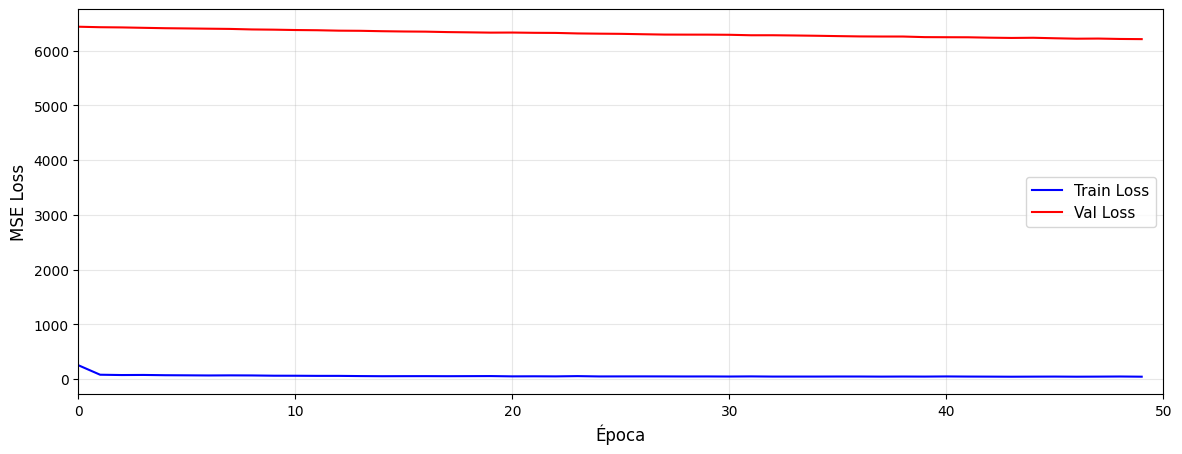

In [12]:
EPOCHS = 50

# Extraer los mejores hyperparámetros
best_params = best_trial.params

# Combinar train set + validation set
X_train_final = torch.FloatTensor(np.concat([X_train, X_val], axis=0)).to(device)
y_train_final = torch.FloatTensor(np.concat([y_train, y_val], axis=0)).to(device).reshape(-1,1)
train_ds = TensorDataset(X_train_final, y_train_final)

# Crear DataLoader con el batch size correspondiente
train_loader = DataLoader(train_ds, batch_size=best_params["batch_size"])
test_loader = DataLoader(test_ds, batch_size=best_params["batch_size"])

# Definir modelo
final_model = FlexibleModel(
                            input_size = input_size,
                            device = device,
                            hidden_layers=best_params['hidden_layers'],
                            hidden_units=best_params['hidden_units'],
                            dropout_rate=best_params['dropout_rate']
                        ).to(device)

# Entrenar modelo
history = train_model(final_model, train_loader, test_loader, EPOCHS, lr = best_params["learning_rate"])

plot_learning_curve(history)

## Paso 5: Evaluación final en set de test

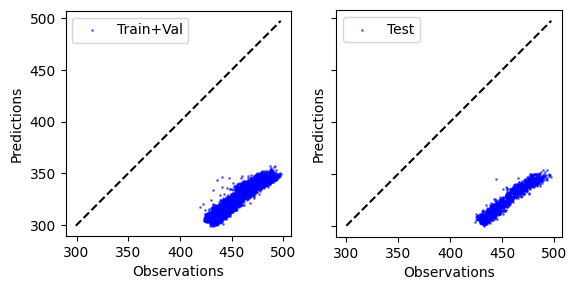

In [23]:
def plot_pred_vs_obs(model, X_obs, y_obs, ax=None, title=None, label=None):
    if not ax:
        fig, ax = plt.subplots(1, 1)

    if isinstance(model, torch.nn.Module):
        device = model.device
        X_obs = torch.FloatTensor(X_obs).to(device)
        y_pred = model(X_obs).detach().numpy().squeeze()
    else:
        y_pred = model.predict(X_obs)
    ax.scatter(y_obs, y_pred, alpha=0.5, label=label, c="blue", s=1.0)
    ax.set_xlabel("Observations")
    ax.set_ylabel("Predictions")
    if title:
        ax.set_title(title)
    if len(y_obs.shape)>1:
        y_obs = y_obs.squeeze()
    if len(y_pred.shape)>1:
        y_pred = y_pred.squeeze()
    p1 = max(max(y_obs), max(y_pred))
    p2 = min(min(y_obs), min(y_pred))
    ax.plot([p2, p1], [p2, p1], "--k")
    ax.legend()
    ax.set_aspect("equal")

fig, axes = plt.subplots(1,2,sharey=True )

plot_pred_vs_obs(final_model, X_train_final, y_train_final, axes[0], label = "Train+Val")
plot_pred_vs_obs(final_model, X_test.values, y_test, axes[1], label = "Test")